In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, database_dir, mplstyle_path
from stats_utils import get_bootstrap_spread
from summary_utils import annotate_unit_df, select_units, summarize_results_per_region, region_palette

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
# analysis-specific conditions
# - model fit
analysis_name1 = 'vision_model'
suffix1s = ('-1pt-ifix0', '-1pt-ifix1')
results_dir1s = tuple(analysis_dir + analysis_name1 + suffix1 for suffix1 in suffix1s)
# - self-consistency ceiling
analysis_name2 = 'rsc_1pt'
results_dir2 = analysis_dir + analysis_name2
# - tally conditions
conds = ('self_cons',) + tuple(f'model_fit{i}' for i in range(len(results_dir1s)))

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'ci_of_mean'

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in conds}

results_dir1s = tuple(Path(d).expanduser() for d in results_dir1s)
results_dir2 = Path(results_dir2).expanduser()
fns = {v.name for v in results_dir2.glob('*.h5')}
for d in results_dir1s:
    fns &= {v.name for v in d.glob('*.h5')}

for fn in fns:
    fp1s = tuple(d / fn for d in results_dir1s)
    fp2 = results_dir2 / fn

    f1s = tuple(h5.File(fp, 'r') for fp in fp1s)
    with h5.File(fp2, 'r') as f2:
        try:
            for f1 in f1s:
                assert f1[f'progress_report/{analysis_name1}/all_done'][()]
            dset1s = tuple(f1['vision_model/data'] for f1 in f1s)
            assert f2[f'progress_report/{analysis_name2}/all_done'][()]
            dset2 = f2['rsc_1pt/current']
            assert isinstance(dset2, h5.Group)
        except (KeyError, AssertionError):
            continue

        # find units shared across all analyses ...
        unit_names1s = []
        unit_names2 = dset2['unit'][()].astype(str)
        unit_names = unit_names2
        for dset1 in dset1s:
            unit_names1 = dset1['unit'][()].astype(str)
            unit_names1s.append(unit_names1)
            unit_names = np.intersect1d(unit_names, unit_names1)
        # .. and determine the units' indices
        sel1s = []
        for unit_names1 in unit_names1s:
            sel1s.append(np.intersect1d(unit_names1, unit_names, assume_unique=True, return_indices=True)[1])
        sel2 = np.intersect1d(unit_names2, unit_names, assume_unique=True, return_indices=True)[1]

        # load data, aligning units
        for i, (dset1, sel1) in enumerate(zip(dset1s, sel1s)):
            results[f'model_fit{i}'].append(dset1['corr'][()][:,sel1].ravel())  # shape (nu,)
        results['self_cons'].append(dset2['sample'][()][sel2])  # shape (nu,)
    for f in f1s: f.close()

    unit_df['Session'].append(np.full(unit_names.size, fp2.stem))
    unit_df['Unit'].append(unit_names)

print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

results:
	self_cons      	(66074,)	float32
	model_fit0     	(66074,)	float32
	model_fit1     	(66074,)	float32
	Session        	(66074,)	<U10
	Unit           	(66074,)	<U4
671 sessions


# Normalize model fit

In [5]:
b = results['self_cons']
b = np.ma.masked_array(b, mask=b<=0)  # norm by non-positive self-cons is undefined
conds2 = conds
for i in range(len(results_dir1s)):
    a = results[f'model_fit{i}']
    results[f'norm_fit{i}'] = np.square(np.clip(a/b, 0, 1))
    conds2 = conds2 + (f'norm_fit{i}',)

# Select units

In [6]:
result_vals = np.array(list(results.values()))
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)

result_vals = result_vals[...,unit_sel]
for k, v in results.items():
    results[k] = v[unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig6b.csv.gz', index=False)

> Selected units: n = 26889 of 66074 (40.7% of data, 99.7% of selection) based on visually_selective.csv.gz
> Selected units: n = 26887 of 26889 (100.0%) with valid values
> Excluded 2 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Ot           7     0.010946
	CIT    Re          28     0.023870
  Selected units: n = 26852 of 26887 (99.9%)


Save well-fit units only for downstream analyses

In [7]:
m = results['norm_fit1'] >= .5
unit_df[m].reset_index()[['Session', 'Unit']].to_csv('unit_sel/well_fit.csv.gz', index=False)

# Summarize results per region

In [8]:
plot_conds = sorted(n for n in conds2 if n.startswith('norm_fit'))
result_vals = np.array([results[c] for c in plot_conds])

In [9]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals[:,None,:],
    spread_type=spread_type)

In [10]:
bysubj_summary = {}
for subj in unit_df['Subject'].unique():
    sel = np.nonzero(unit_df['Subject'].values==subj)[0]
    bysubj_summary[subj] = summarize_results_per_region(
        unit_df=unit_df.iloc[sel],
        result_vals=result_vals[:,None,sel],
        spread_type=spread_type)

center/spread estimate: ci_of_mean


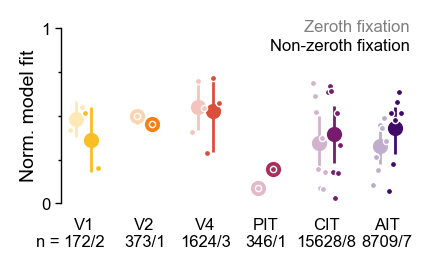

In [11]:
fig = plt.figure(figsize=(2.25,1.25))
ax = plt.gca()

width = .25
width2 = .8
xs = np.zeros(1) if len(plot_conds) == 1 else np.arange(len(plot_conds))/(len(plot_conds)-1) - .5

for icond in range(len(plot_conds)):
    for ireg, region in enumerate(regions):
        c = region_palette[region]
        if icond == 0:
            c = (2 + c) / 3

        # plot region-level
        m, bs = summary['one-level_center_boots'][region]
        m = m[icond,0]
        bs = bs[:,icond,0]
        x = ireg + width * xs[icond]
        ax.scatter(x, m, color=c, s=20)
        spread = get_bootstrap_spread(m, bs, spread_type)
        ax.vlines(x, *spread, color=c)

        # plot subject-level
        subjs = np.array([
            k for k, v in bysubj_summary.items()
            if region in v['one-level_center_boots']])
        js = np.zeros(1) if subjs.size == 1 else np.arange(subjs.size)/(subjs.size-1) - .5
        js = x + width * width2 * js
        for j, subj in zip(js, subjs):
            m = bysubj_summary[subj]['one-level_center_boots'][region][0][icond,0]
            ax.scatter(j, m, fc=c, ec='w', s=5, lw=0.5, zorder=3)

xtkls = []
for i, region in enumerate(regions):
    ns = np.array(list(summary['two-level_nunit'][region].values()))
    xtkls.append(f'{region}\n{ns.sum()}/{ns.size}')
ax.set_xlim(-width*1.5, len(regions)-1+width*1.5)
ax.set_xticks(range(len(xtkls)), xtkls)
ax.tick_params(axis='x', length=0)
ax.spines['bottom'].set_visible(False)

ylim = (-.05, 1.05)
ybound = (0, 1)
ax.set_ylim(ylim)
ax.set_yticks(ybound, tuple(map(str, ybound)))
ax.set_yticks(np.arange(*ybound,.25), minor=True)
ax.spines['left'].set_bounds(ybound)
ax.set_ylabel('Norm. model fit')

h = 1
for l, c in zip(
        ('Zeroth fixation','Non-zeroth fixation'),
        ('gray','k')):
    ax.text(
        1, h, l, ha='right', va='top',
        transform=ax.transAxes, color=c, fontsize=6)
    h -= .1

t = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.text(
    -.6, -.115, f'n =', ha='center', va='top',
    fontsize=6, transform=t)

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig6b.png')

In [12]:
print('center/spread estimate:', spread_type)
for ires, res in enumerate(plot_conds):
    print(res)
    for i, region in enumerate(regions):
        m, bs = summary['one-level_center_boots'][region]
        m = m[ires,0]
        bs = bs[:,ires,0]
        if spread_type == 'ci_of_mean':
            spread = get_bootstrap_spread(m, bs, spread_type)
            print(f'{region}:\t{m:3.2f}, {spread[0]:3.2f} -- {spread[1]:3.2f}')
        else:
            d = get_bootstrap_spread(m, bs, spread_type, return_dev=True)
            print(f'{region}:\t{m:3.2f} +/- {d:3.2f}')
    print()

center/spread estimate: ci_of_mean
norm_fit0
V1:	0.48, 0.38 -- 0.59
V2:	0.50, 0.45 -- 0.54
V4:	0.55, 0.42 -- 0.70
PIT:	0.09, 0.06 -- 0.11
CIT:	0.34, 0.19 -- 0.50
AIT:	0.33, 0.22 -- 0.41

norm_fit1
V1:	0.36, 0.18 -- 0.55
V2:	0.45, 0.41 -- 0.49
V4:	0.53, 0.29 -- 0.71
PIT:	0.20, 0.17 -- 0.23
CIT:	0.40, 0.23 -- 0.55
AIT:	0.43, 0.28 -- 0.55

